In [1]:
import torch
from autoemulate.experimental.emulators import GaussianProcessExact
from autoemulate.experimental.emulators.random_forest import RandomForest
from autoemulate.experimental.emulators.transformed.base import TransformedEmulator
from autoemulate.experimental.transforms import PCATransform, VAETransform, StandardizeTransform
from sklearn.datasets import make_regression
import torchmetrics
from autoemulate.experimental.model_selection import evaluate
from autoemulate.experimental.types import TensorLike

# Uncomment to enable logging for GPs
import logging
# logging.basicConfig(level=logging.INFO)

def make_data(
    random_state: int = 42,
    n_samples: int = 200,
    n_informative:int = 2,
    n_features: int = 5,
    noise: float = 0.2,
    n_targets: int = 500
):
    x, y, _ = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state,
        n_informative=n_informative,
        n_targets=n_targets,
        coef=True,
    )
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y

# Train data
x, y = make_data(random_state=42, n_targets=10)

# Test data
x2, y2 = make_data(random_state=43, n_targets=10)

# Make transform
pca = PCATransform(n_components=2)
pca.fit(x)

# Transform data
print(pca(x).shape)

# Invert PCA on tensor
print(pca.inv(pca(x)).shape)

torch.Size([200, 2])
torch.Size([200, 5])


In [2]:
# Example y transform
pca_y = PCATransform(n_components=1)
pca_y.fit(y)
print(pca_y(y)[:10].shape)
print(pca_y.inv(pca_y(y))[:10].shape)


torch.Size([10, 1])
torch.Size([10, 10])


In [3]:
emulator = TransformedEmulator(
    x=x,
    y=y,
    x_transforms=[PCATransform(n_components=4), VAETransform(latent_dim=2)],
    y_transforms=[StandardizeTransform(), PCATransform(n_components=1)],
    model=GaussianProcessExact,
    epochs=100,
)

In [4]:
emulator.fit(x, y)

In [5]:
emulator.full_covariance

False

In [6]:
# Fit
emulator.fit(x, y)

In [7]:
# Predict on training data
pred = emulator.predict(x[:30])


/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/transforms/base.py:87: NumericalWarning: cov not p.d. - added 1.0e-04 to the diagonal and symmetrized
  cov_orig = make_positive_definite(cov_orig)


In [ ]:
# Example using transformed emulator with GP and Random Forest
from autoemulate.experimental.model_selection import r2_metric


for model in [GaussianProcessExact, RandomForest]:
    # Create transformed emulator with GP
    emulator = TransformedEmulator(
        x=x,
        y=y,
        x_transforms=[PCATransform(n_components=4), VAETransform(latent_dim=2)],
        y_transforms=[StandardizeTransform(), PCATransform(n_components=1)],
        model=model,
        epochs=100,
    )

    # Fit
    emulator.fit(x, y)

    # Predict on training data
    pred = emulator.predict(x[:30])
    pred = pred if isinstance(pred, TensorLike) else pred.mean
    print(f"Train R2: {evaluate(pred, y[:30], r2_metric()):.3f}")

    # Predict on test data
    pred = emulator.predict(x2)
    pred = pred if isinstance(pred, TensorLike) else pred.mean
    print(f"Test  R2: {evaluate(pred, y2, r2_metric()):.3f}")

Train R2: 0.394
Test  R2: -26.441
Train R2: 0.746
Test  R2: -31.345


In [9]:
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal

# Mean zero as just test covariance
mean = torch.zeros(1, 10)
cov = torch.eye(10)
mvn = MultitaskMultivariateNormal(mean=mean, covariance_matrix=cov)

# Generate some samples
torch.manual_seed(42)
scales = torch.randint(100, size=(1, 10), dtype=torch.float32)
samples= MultivariateNormal(mean=mean, covariance_matrix=cov * scales).sample(torch.Size([100])).squeeze()

# Fit standardize transform
t = StandardizeTransform()
t.fit(samples)

In [10]:
# Compare inverse from sampling and analytical solution
sampled = t._inverse_sample(mvn, n_samples=10000).covariance_matrix
analytical = t._inverse_gaussian(mvn).covariance_matrix
diff = sampled - analytical
diff_normed = diff.abs() / sampled
torch.allclose(diff_normed.diagonal(), torch.zeros_like(diff_normed).diagonal(), atol=0.05)

True

VAETransform()


/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/transforms/base.py:66: NumericalWarning: cov not p.d. - added 1.0e-04 to the diagonal and symmetrized
  make_positive_definite(samples.view(n_samples, -1).T.cov())
/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/transforms/base.py:87: NumericalWarning: cov not p.d. - added 1.0e-05 to the diagonal and symmetrized
  cov_orig = make_positive_definite(cov_orig)


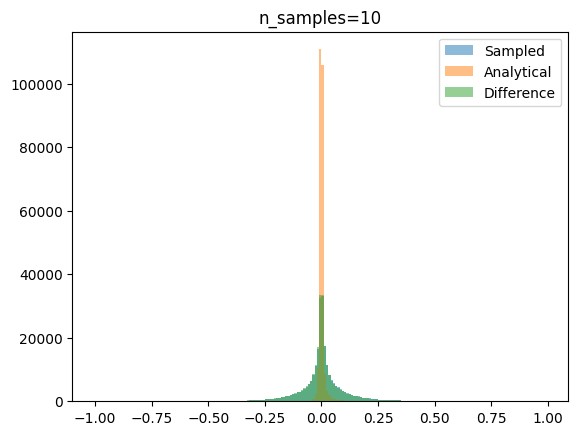

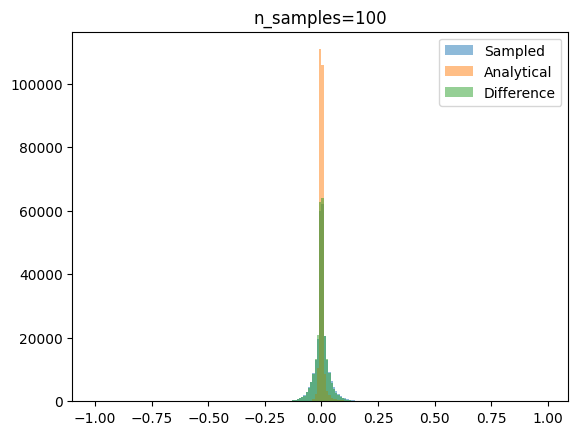

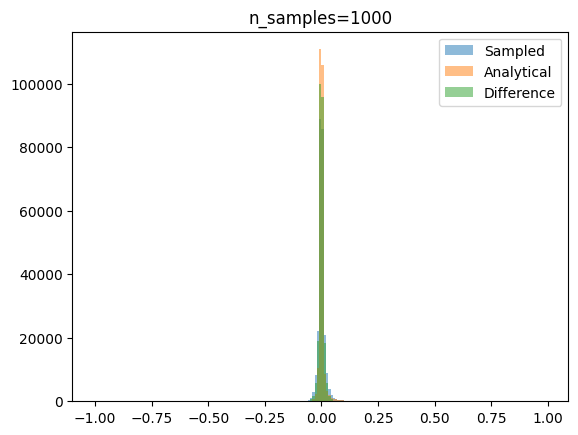

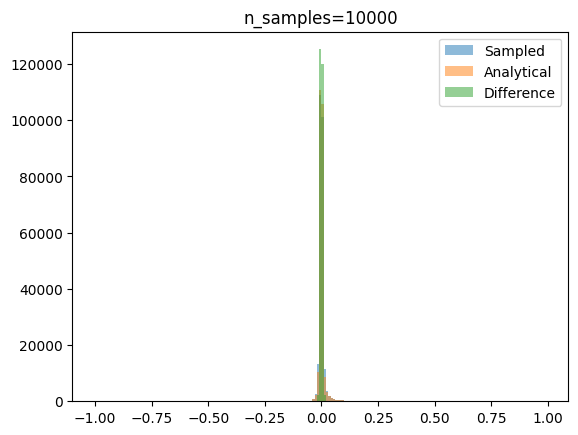

PCATransform()


/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/transforms/base.py:66: NumericalWarning: cov not p.d. - added 1.0e-05 to the diagonal and symmetrized
  make_positive_definite(samples.view(n_samples, -1).T.cov())


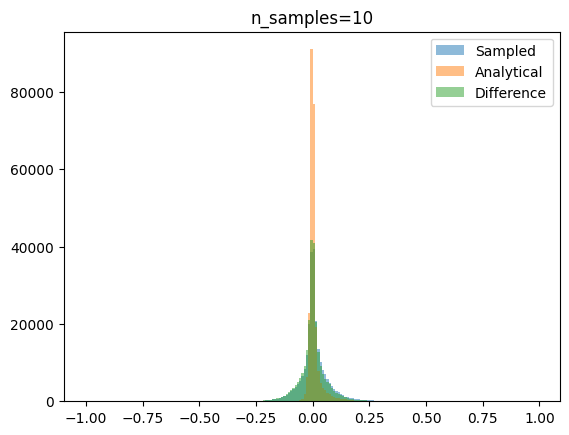

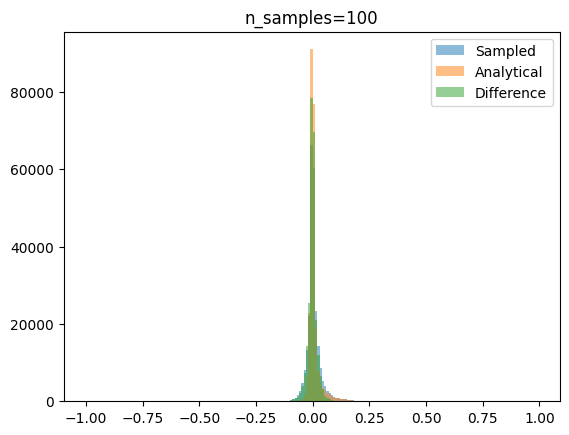

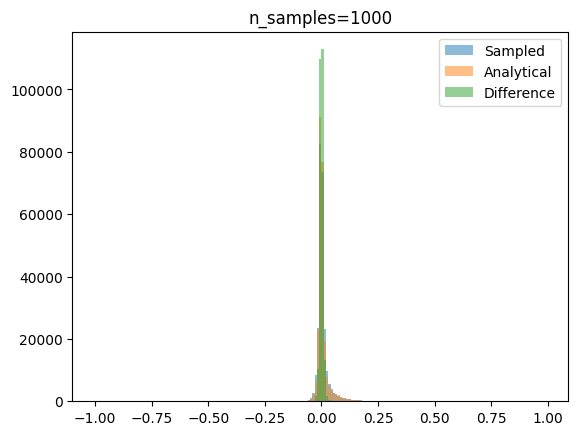

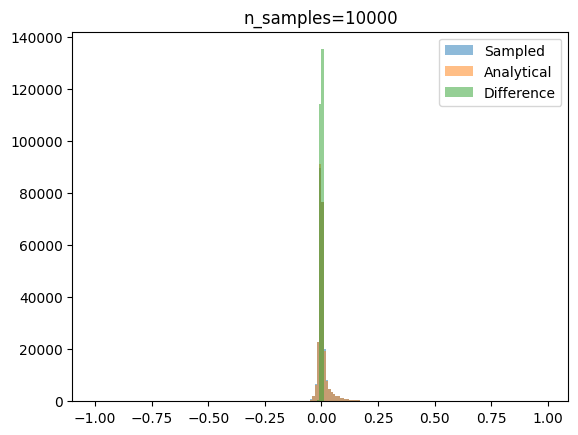

In [11]:
# Compare analytical and sampling solutions for inverse transforms
import matplotlib.pyplot as plt
import numpy as np
from autoemulate.experimental.types import GaussianLike

for t in [VAETransform(latent_dim=2), PCATransform(n_components=2)]:
    x, y = make_data(n_targets=5, n_samples=200)
    t.fit(y)
    z = t(y)
    gp = GaussianProcessExact(x, z)
    gp.fit(x, z)
    z_pred = gp.predict(x[: x.shape[0] // 2])
    assert isinstance(z_pred, GaussianLike)

    print(str(t))
    for n_samples in [10, 100, 1000, 10000]:
        inv_sample = t._inverse_sample(z_pred, n_samples=n_samples)
        inv_gaussian = t._inverse_gaussian(z_pred)
        diff = inv_sample.covariance_matrix - inv_gaussian.covariance_matrix
        plt.title(f"n_samples={n_samples}")
        plt.hist(inv_sample.covariance_matrix.flatten().detach().numpy(), bins=np.arange(-1, 1, 0.01), alpha=0.5, label='Sampled')
        plt.hist(inv_gaussian.covariance_matrix.flatten().detach().numpy(), bins=np.arange(-1, 1, 0.01), alpha=0.5, label="Analytical")
        plt.hist(diff.flatten().detach().numpy(), bins=np.arange(-1, 1, 0.01), alpha=0.5, label='Difference')
        plt.legend()
        plt.show()

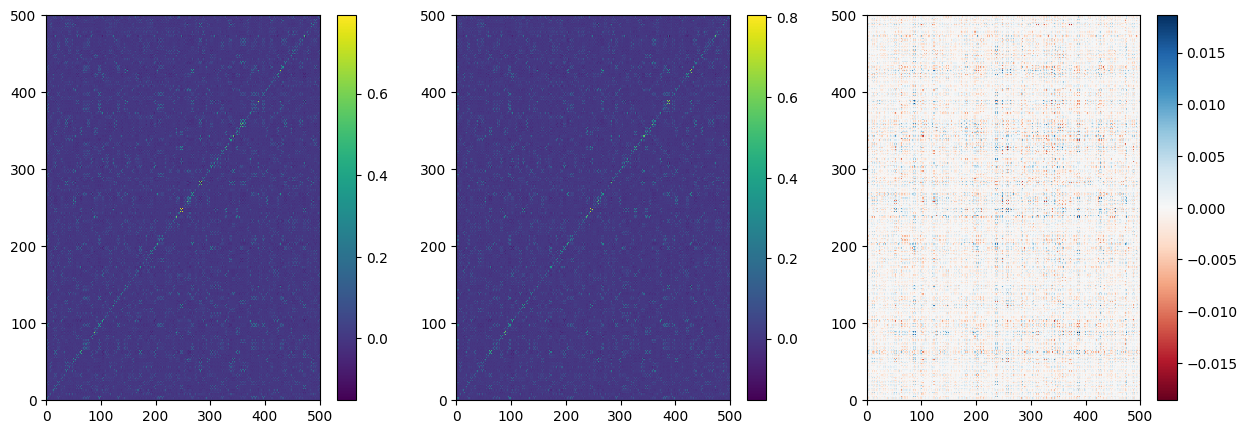

In [12]:
# Visualize the covariance matrices and difference
diff = (inv_gaussian.covariance_matrix - inv_sample.covariance_matrix)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, x_ in enumerate([inv_gaussian.covariance_matrix, inv_sample.covariance_matrix, diff]):
    x = x_.detach().numpy()
    if idx > 1:
        hmap = axs[idx].pcolormesh(x, vmin=-np.abs(x).max(), vmax=np.abs(x).max(), cmap="RdBu")
    else:
        hmap = axs[idx].pcolormesh(x)
    plt.colorbar(hmap)

/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/emulators/transformed/base.py:197: NumericalWarning: cov not p.d. - added 1.0e-05 to the diagonal and symmetrized
  make_positive_definite(samples.view(self.n_samples, -1).T.cov())


VAETransform()


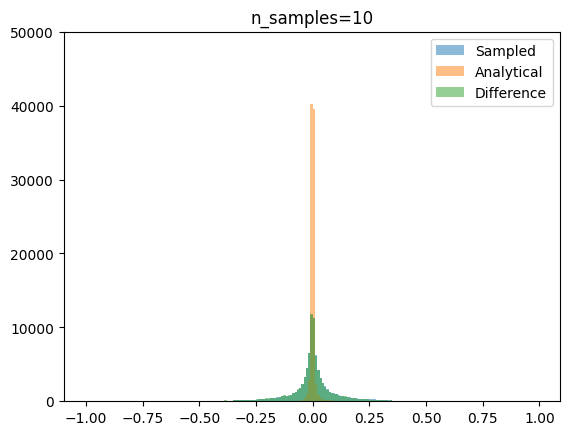

VAETransform()


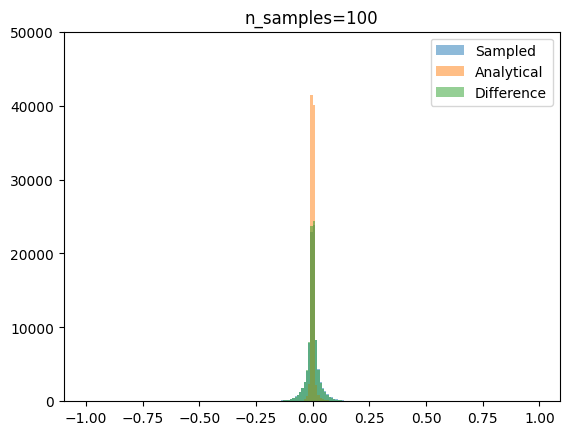

VAETransform()


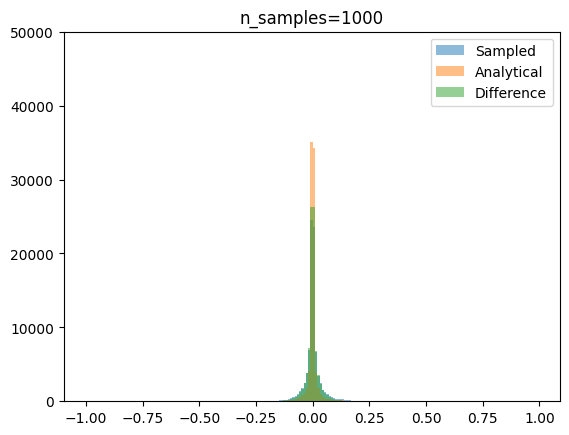

/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/transforms/base.py:87: NumericalWarning: cov not p.d. - added 1.0e-04 to the diagonal and symmetrized
  cov_orig = make_positive_definite(cov_orig)
/Users/sgreenbury/Projects/fundamentals/autoemulate/autoemulate/experimental/emulators/transformed/base.py:197: NumericalWarning: cov not p.d. - added 1.0e-04 to the diagonal and symmetrized
  make_positive_definite(samples.view(self.n_samples, -1).T.cov())


VAETransform()


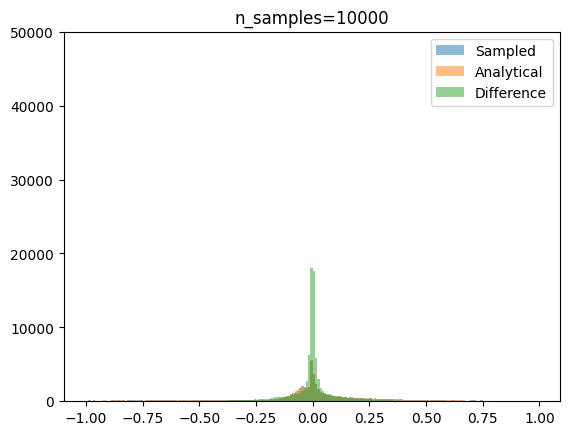

PCATransform()


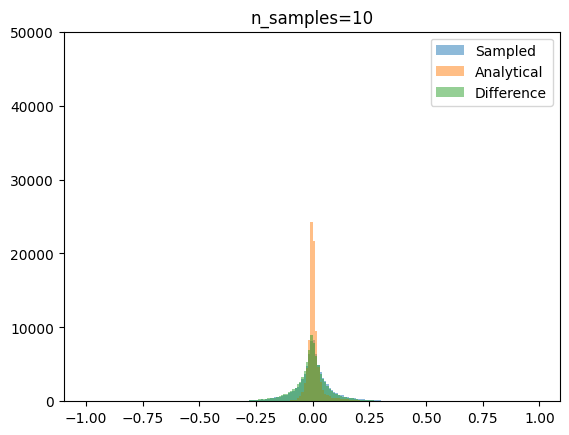

PCATransform()


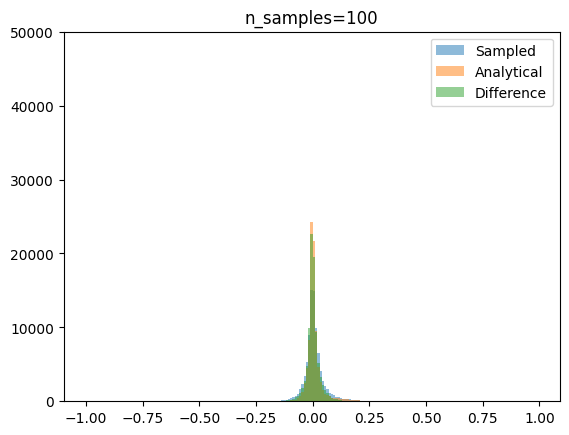

PCATransform()


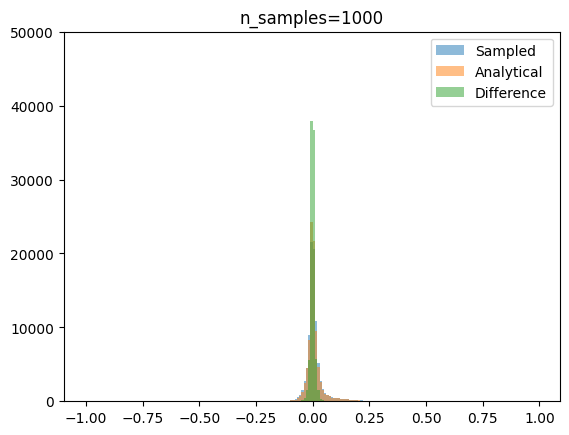

PCATransform()


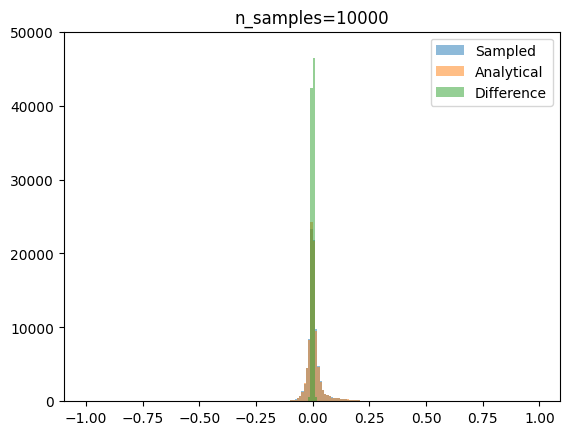

In [13]:
# Compare analytical and sampling solutions for transformed emulators without standardization
import matplotlib.pyplot as plt
import numpy as np
from autoemulate.experimental.types import GaussianLike

for t in [VAETransform(latent_dim=2), PCATransform(n_components=2)]:
    x, y = make_data(n_targets=3)
    for n_samples in [10, 100, 1000, 10000]:
        gp = TransformedEmulator(
            x=x,
            y=y,
            y_transforms=[t],
            x_transforms=[],
            model=GaussianProcessExact,
            epochs=50,
            n_samples=n_samples,
            full_covariance=True,
            output_from_samples=False
        )
        gp.fit(x, y)
        # z_pred = gp.model.predict(gp.transforms[0](x[: x.shape[0] // 2]))
        z_pred = gp.model.predict(x[: x.shape[0] // 2])
        assert isinstance(z_pred, GaussianLike)
        inv_gaussian = gp._inv_transform_y_mvn(z_pred)
        inv_sample = gp._inv_transform_y_mvn_sample(z_pred)
        print(str(t))
        diff = inv_sample.covariance_matrix - inv_gaussian.covariance_matrix
        plt.title(f"n_samples={n_samples}")
        plt.ylim(0, 50000)
        plt.hist(inv_sample.covariance_matrix.flatten().detach().numpy(), bins=list(np.arange(-1, 1, 0.01)), alpha=0.5, label='Sampled')
        plt.hist(inv_gaussian.covariance_matrix.flatten().detach().numpy(), bins=list(np.arange(-1, 1, 0.01)), alpha=0.5, label='Analytical')
        plt.hist(diff.flatten().detach().numpy(), bins=list(np.arange(-1, 1, 0.01)), alpha=0.5, label='Difference')
        plt.legend()
        plt.show()

/Users/sgreenbury/Projects/fundamentals/autoemulate/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/sgreenbury/Projects/fundamentals/autoemulate/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/sgreenbury/Projects/fundamentals/autoemulate/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


VAETransform()


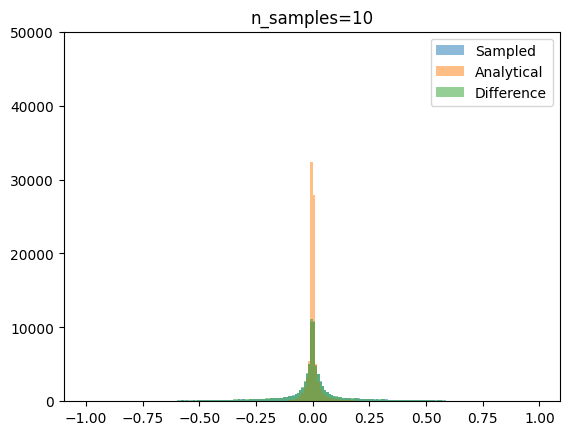

VAETransform()


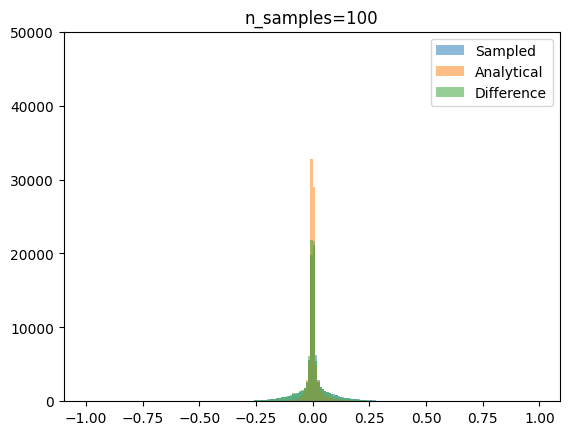

VAETransform()


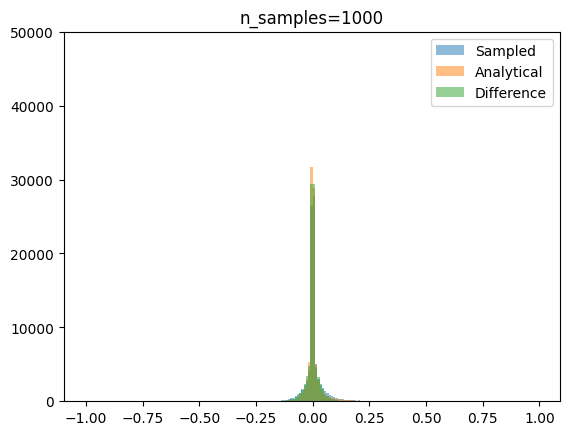

VAETransform()


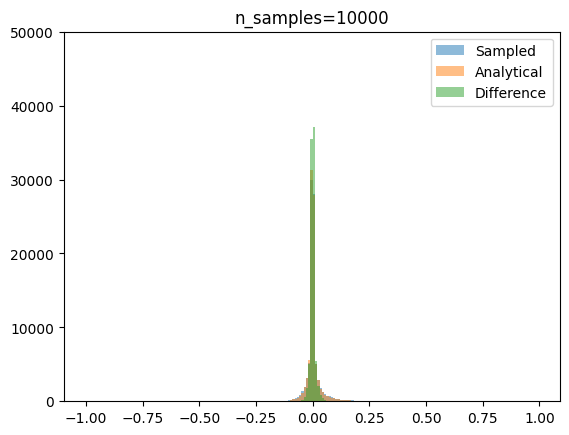

PCATransform()


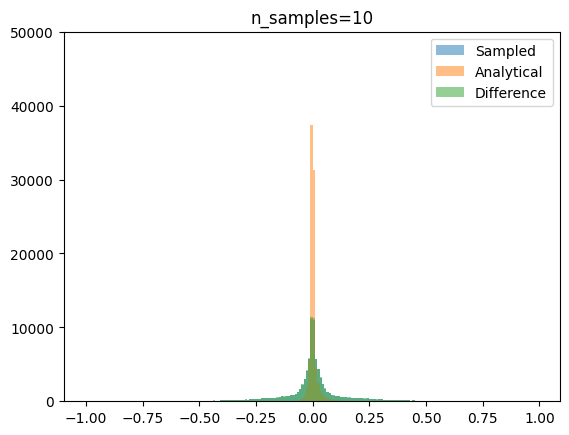

PCATransform()


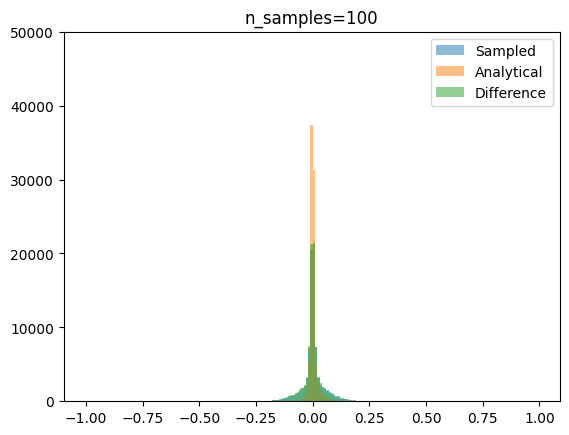

PCATransform()


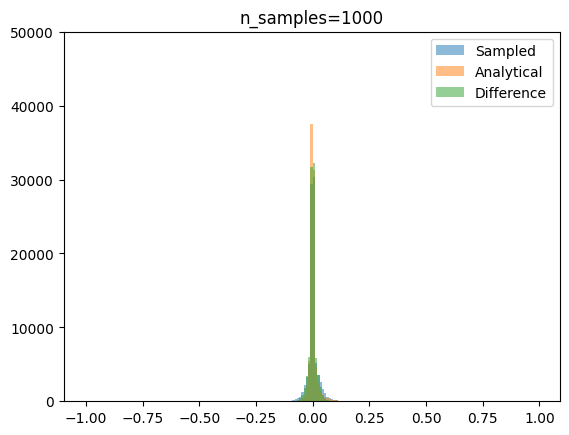

PCATransform()


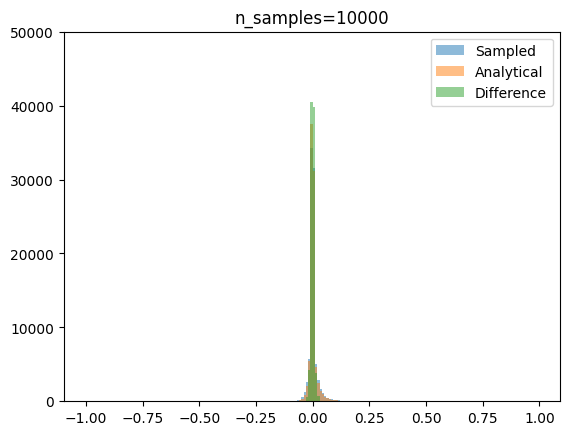

In [14]:
# Compare analytical and sampling solutions for transformed emulators with standardization
import matplotlib.pyplot as plt
import numpy as np
from autoemulate.experimental.types import GaussianLike

for t in [VAETransform(latent_dim=2), PCATransform(n_components=2)]:
    x, y = make_data(n_targets=3)
    for n_samples in [10, 100, 1000, 10000]:
        gp = TransformedEmulator(
            x=x,
            y=y,
            x_transforms=[StandardizeTransform()],
            y_transforms=[StandardizeTransform(), t],
            model=GaussianProcessExact,
            epochs=50,
            n_samples=n_samples,
            full_covariance=True,
            output_from_samples=False
        )
        gp.fit(x, y)
        # z_pred = gp.model.predict(gp.transforms[0](x[: x.shape[0] // 2]))
        z_pred = gp.model.predict(x[: x.shape[0] // 2])
        assert isinstance(z_pred, GaussianLike)
        inv_gaussian = gp._inv_transform_y_mvn(z_pred)
        inv_sample = gp._inv_transform_y_mvn_sample(z_pred)
        print(str(t))
        diff = inv_sample.covariance_matrix - inv_gaussian.covariance_matrix
        plt.title(f"n_samples={n_samples}")
        plt.ylim(0, 50000)
        plt.hist(inv_sample.covariance_matrix.flatten().detach().numpy(), bins=list(np.arange(-1, 1, 0.01)), alpha=0.5, label='Sampled')
        plt.hist(inv_gaussian.covariance_matrix.flatten().detach().numpy(), bins=list(np.arange(-1, 1, 0.01)), alpha=0.5, label='Analytical')
        plt.hist(diff.flatten().detach().numpy(), bins=list(np.arange(-1, 1, 0.01)), alpha=0.5, label='Difference')
        plt.legend()
        plt.show()